In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint


In [3]:
df = pd.read_csv('EV_sales.csv')

### EV Car Sales Between 2010 and 2024

#### About this file:
- region: Geographical area where the data was collected (e.g., Australia)
- category: Nature of the data (e.g., Historical, Projection)
- parameter: Type of metric (e.g., EV sales, EV stock share)
- mode: Mode of transport (e.g., Cars)
- powertrain: Type of EV: BEV (Battery Electric Vehicle), PHEV (Plug-in Hybrid - EV), EV
- year: Year of the data point (e.g., 2011, 2012)
- unit: Measurement unit (e.g., Vehicles, percent)
- value: Actual recorded value

#### Objective:

To know how are EVs evolving in three European markets (Spain, France and Germany) compared to the tendencies shown in the European Union. We want to know which are evolving faster, what are some strong and weak points, and to do some short term predictions for the year 2030 as per the objectives of the UN's 2030 Agenda.

In [4]:
df.head()

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49.00000
1,Australia,Historical,EV stock share,Cars,EV,2011,percent,0.00039
2,Australia,Historical,EV sales share,Cars,EV,2011,percent,0.00650
3,Australia,Historical,EV stock,Cars,BEV,2011,Vehicles,49.00000
4,Australia,Historical,EV stock,Cars,BEV,2012,Vehicles,220.00000


The first step, after getting a general idea of how the DF looks, is to drop the data that's not directly relevant or that doesn't provide any meaningful insight, and to leave only those that are worth studying deeper.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      3798 non-null   object 
 1   category    3798 non-null   object 
 2   parameter   3798 non-null   object 
 3   mode        3798 non-null   object 
 4   powertrain  3798 non-null   object 
 5   year        3798 non-null   int64  
 6   unit        3798 non-null   object 
 7   value       3798 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 237.5+ KB


In [6]:
columns = ['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit']

for column in columns:
    print(f"{column}'s unique values:\n{df[column].unique()}\n")

region's unique values:
['Australia' 'Austria' 'Belgium' 'Brazil' 'Bulgaria' 'Canada' 'Chile'
 'China' 'Colombia' 'Costa Rica' 'Croatia' 'Cyprus' 'Czech Republic'
 'Denmark' 'Estonia' 'EU27' 'Europe' 'Finland' 'France' 'Germany' 'Greece'
 'Hungary' 'Iceland' 'India' 'Ireland' 'Israel' 'Italy' 'Japan' 'Korea'
 'Latvia' 'Lithuania' 'Luxembourg' 'Mexico' 'Netherlands' 'New Zealand'
 'Norway' 'Poland' 'Portugal' 'Rest of the world' 'Romania' 'Seychelles'
 'Slovakia' 'Slovenia' 'South Africa' 'Spain' 'Sweden' 'Switzerland'
 'Turkiye' 'United Arab Emirates' 'United Kingdom' 'USA' 'World']

category's unique values:
['Historical']

parameter's unique values:
['EV sales' 'EV stock share' 'EV sales share' 'EV stock'
 'Electricity demand' 'Oil displacement Mbd'
 'Oil displacement, million lge']

mode's unique values:
['Cars']

powertrain's unique values:
['BEV' 'EV' 'PHEV' 'FCEV']

year's unique values:
[2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2010]

unit's unique values

Since both the "category" and the "mode" columns do not add any meaningful information to the database, it is safe to say we can drop them entirely from it, keeping in mind that all data is based on actual recorded measurements, and that all the vehicles present in the database are EV cars.

In [7]:
df = df.drop(columns=['category', 'mode'])

Additionally, since we are analysing only EV sales and their share in the market overall, it is safe to assume there is more information stored within the database than we need. Hence, it is necessary to clean up the data to keep only what is currently relevant for our study.

In [8]:
# Method A: By keeping only rows where the boolean returns "True"
units_to_remove = ['GWh', 'Milion barrels per day', 'Oil displacement, million lge']
df_units_cleaned = df[~df['unit'].isin(units_to_remove)]
# '~' negates the condition: it keeps only rows NOT containing unwanted units
df_units_cleaned['unit'].unique()

array(['Vehicles', 'percent'], dtype=object)

In [9]:
# Method B: By creating a copy only with the rows we want to keep
ev_parameters = ['EV sales', 'EV stock', 'EV sales share', 'EV stock share']
df_clean = df_units_cleaned[df_units_cleaned['parameter'].isin(ev_parameters)].copy()
df_clean['parameter'].unique()

array(['EV sales', 'EV stock share', 'EV sales share', 'EV stock'],
      dtype=object)

Note: Since both are directly correlated, by using only one of the previous steps, the database is already cleant. This is only for demonstration purposes.

In [10]:
df_clean[(df_clean['region']=='Australia') & (df_clean['year']==2012)]

,region,parameter,powertrain,year,unit,value
4,Australia,EV stock,BEV,2012,Vehicles,220.0000
5,Australia,EV stock,PHEV,2012,Vehicles,80.0000
6,Australia,EV sales,PHEV,2012,Vehicles,80.0000
7,Australia,EV sales share,EV,2012,percent,0.0300
8,Australia,EV stock share,EV,2012,percent,0.0024
9,Australia,EV sales,BEV,2012,Vehicles,170.0000


In the previous cell, we can observe that there are two different key units in this database to differenciate — Vehicle counts (physical stock and sales) and Percentages, over the total population of vehicles. The two units cannot be superposed, so it is necessary to separate them in two different sub-dataframes to analyse individually.

In [11]:
df_vehicles = df[df['unit'] == 'Vehicles']
df_percent = df[df['unit'] == 'percent']

Additionally, in df_vehicles, since all values must be integers (can't sell/stock half a car) the following helps making data clearer:

In [12]:
df_vehicles.loc[:, 'value'] = df_vehicles.loc[:, 'value'].astype(int)

Let's see what powertrain counts can be observed in the database for vehicles sold, so we can get an idea of what categories we can find:

In [13]:
df_vehicles['powertrain'].value_counts()

powertrain
BEV     1078
PHEV     922
FCEV     487
Name: count, dtype: int64

If we do the same with the newly created df_percent DF, we can observe that only one category 'EV' appears. That's because an electric vehicle usually comprehends any vehicle that can move fully on battery power, and PHEVs can do so even if the main power is usually the ICE engine. 

In [14]:
df_percent['powertrain'].value_counts()

powertrain
EV    1068
Name: count, dtype: int64

### 1. Sales Figures

In [15]:
df_vehicles['parameter'].value_counts()

parameter
EV sales    1342
EV stock    1145
Name: count, dtype: int64

As we can observe, the database contains two distinct parameters for measuring electric vehicles: EV stock and EV sales. EV stock represents the total number of electric vehicles available in a country at a given time, while EV sales represent the number of vehicles actually sold during a specific period. Naturally, sales numbers should always be lower than stock, but analyzing the gap between them over recent years can offer valuable insights into the market’s growth dynamics and saturation levels.

The following distinction will be made, hence, to accomodate these two different data types.

In [16]:
df_vehicles_sales = df_vehicles[df_vehicles['parameter'] == 'EV sales']
df_vehicles_stock = df_vehicles[df_vehicles['parameter'] == 'EV stock']

### 1.1. EV Sales

First, lets analyse EV sales... how have they evolved in the world? In what categories are they classified? The analysis includes several overviews with insights regarding evolution through the years. All columns offer essential data regarding region and their own EV market evolution, as well as how each specific EV powertrain is doing in those regions...

But first of all, let's see the table we'll be working with to see if anything needs some work.

In [17]:
df_vehicles_sales

,region,parameter,powertrain,year,unit,value
0,Australia,EV sales,BEV,2011,Vehicles,49.0
6,Australia,EV sales,PHEV,2012,Vehicles,80.0
9,Australia,EV sales,BEV,2012,Vehicles,170.0
10,Australia,EV sales,BEV,2013,Vehicles,190.0
13,Australia,EV sales,PHEV,2013,Vehicles,100.0
...,...,...,...,...,...,...
3781,World,EV sales,FCEV,2022,Vehicles,15000.0
3783,World,EV sales,PHEV,2022,Vehicles,2900000.0
3788,World,EV sales,PHEV,2023,Vehicles,4300000.0
3792,World,EV sales,FCEV,2023,Vehicles,8900.0


In [18]:
columns = ['parameter', 'unit']

for column in columns:
    print(f"{column}'s unique values: \n{df_vehicles_sales[column].unique()}\n")

parameter's unique values: 
['EV sales']

unit's unique values: 
['Vehicles']



As expected, what were some essential columns previously, are now unnecessary as they do not provide any relevant information. These are known as "temporary indexing columns" and, in the four sub-databases we created, they will be deleted.

In [19]:
df_vehicles_sales = df_vehicles_sales.drop(['parameter','unit'], axis=1)

In [20]:
df_vehicles_sales

,region,powertrain,year,value
0,Australia,BEV,2011,49.0
6,Australia,PHEV,2012,80.0
9,Australia,BEV,2012,170.0
10,Australia,BEV,2013,190.0
13,Australia,PHEV,2013,100.0
...,...,...,...,...
3781,World,FCEV,2022,15000.0
3783,World,PHEV,2022,2900000.0
3788,World,PHEV,2023,4300000.0
3792,World,FCEV,2023,8900.0


In [21]:
df_vehicles_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1342 entries, 0 to 3794
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      1342 non-null   object 
 1   powertrain  1342 non-null   object 
 2   year        1342 non-null   int64  
 3   value       1342 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 52.4+ KB


So we are left with four columns, two of which are objects and help us categorise the data, one, year,  as integer values, and the last one, value, as the basis for the analysis with float values.

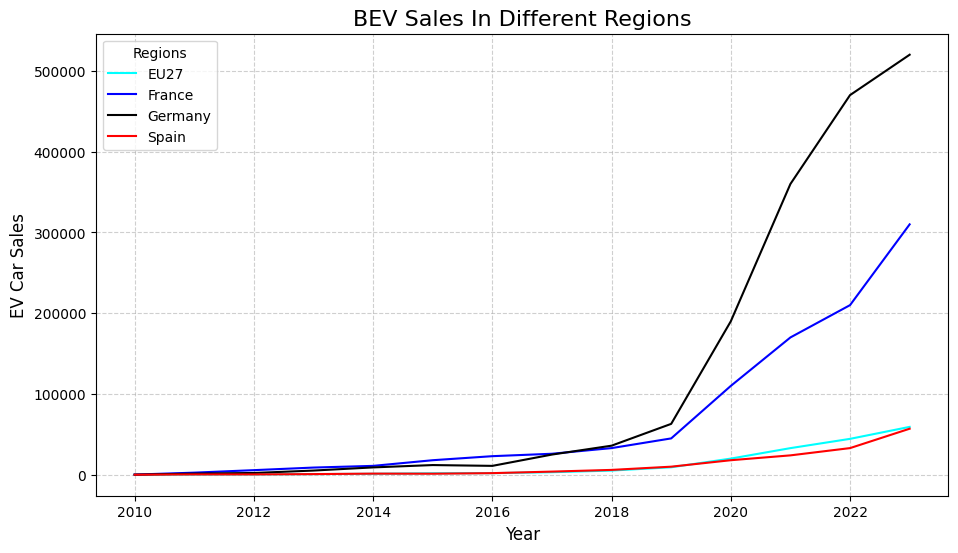

In [22]:
countries = ['Spain', 'Germany', 'France', 'EU27']
bev_data = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'].isin(countries))]
# Adjusts the EU27 region to show the average between the 27 EU members
bev_data.loc[bev_data['region'] == 'EU27', 'value'] /= 27

fig, ax = plt.subplots(figsize=(11, 6))

palette = {
    'Spain': 'red',
    'Germany': 'black',
    'France': 'blue',
    'EU27': 'cyan'
}
sns.lineplot(data=bev_data, x='year', y='value', hue='region', palette=palette,linestyle='-')

ax.set_title('BEV Sales In Different Regions', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('EV Car Sales', fontsize=12)
ax.grid('True', linestyle='--', alpha=0.6)

plt.legend(title='Regions')
plt.show()

We can already see an astonishing difference between the three countries by looking at the previous graph. Germany, being the biggest economy in the union, shows a way stronger trend towards electrification, pushed through and through by both government and car companies, with a breakthrough of 500k vehicles sold by the year 2023. However, a 

France, which lags a bit behind, also did an enormous progress with an even higher tendency, breaking the ceiling of 300k EVs sold by the year 2023 and with a way higher growth than Germany's, which we will explain before.

It is important to mention how, until the year 2018, sales in Spain and, in average, for the EU, were almost non-existant. Only a few thousand, with the exception of France and Germany in this case which hovered around the 40k sales. The increment afterwards however has been exponential, with the arrival of more mainstream EVs made in France and Germany, more affordable Tesla BEVs, and recent chinese BEVs penetrating these markets.

Tendencies, however, diverge. France and Germany show a clear gap, explained partially by the population difference between both countries, but also due to a stronger economy in Germany and more ability to purchase high end EVs where France lagged behind. However, last year showed how German sales stagnated a bit while French ones climbed at at a level never seen before, explained perhaps by more affordable EV cars produced in France, favoured by local consumers.

Spain, at the end, has seen a sharp rise last year, but is still under the EU average, with the possibility to break through at this rate if it is followed next year. However, despite being a very strong economy in the union, it is lagging severely behind and shows probably both reluctance by consumers, and a lack of government initiative to push for the transition.

In [23]:
df_vehicles_sales['year']

0       2011
6       2012
9       2012
10      2013
13      2013
        ... 
3781    2022
3783    2022
3788    2023
3792    2023
3794    2023
Name: year, Length: 1342, dtype: int64

In [24]:
fr_sales_2023 = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'] == 'France') & (df_vehicles_sales['year'] == 2023), 'value'].sum()
fr_sales_2022 = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'] == 'France') & (df_vehicles_sales['year'] == 2022), 'value'].sum()

ger_sales_2023 = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'] == 'Germany') & (df_vehicles_sales['year'] == 2023), 'value'].sum()
ger_sales_2022 = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'] == 'Germany') & (df_vehicles_sales['year'] == 2022), 'value'].sum()

spa_sales_2023 = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'] == 'Spain') & (df_vehicles_sales['year'] == 2023), 'value'].sum()
spa_sales_2022 = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'] == 'Spain') & (df_vehicles_sales['year'] == 2022), 'value'].sum()

eu27_sales_2023 = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'] == 'EU27') & (df_vehicles_sales['year'] == 2023), 'value'].sum()
eu27_sales_2022 = df_vehicles_sales.loc[(df_vehicles_sales['powertrain'] == 'BEV') & (df_vehicles_sales['region'] == 'EU27') & (df_vehicles_sales['year'] == 2022), 'value'].sum()

fr_sales_growth = fr_sales_2023 / fr_sales_2022
ger_sales_growth = ger_sales_2023 / ger_sales_2022
spa_sales_growth = spa_sales_2023 / spa_sales_2022
eu27_sales_growth = eu27_sales_2023 / eu27_sales_2022
print(f"Last year's growth of EV sales was of {(fr_sales_growth-1)*100:.2f}% in France, {(ger_sales_growth-1)*100:.2f}% in Germany, {(spa_sales_growth-1)*100:.2f}% in Spain, while for the European Union it was of {(eu27_sales_growth-1)*100:.2f}%.")

Last year's growth of EV sales was of 47.62% in France, 10.64% in Germany, 72.73% in Spain, while for the European Union it was of 33.33%.


This bit of code is, arguably, excessively long, prone to bugs or errors, and very unreadable. In those cases, especially since the project relies on reusable, clean code that can be used later down the line, it is clear that is not the ideal way to read the evolution of data over the years. That's why down below I will show how to rebuild all of that in a clean, readable function using python's functions.

Additionally, clean reusable code allows to obtain directly usable values that can be computed with a simple function call, and the function itself can be easily modified to adapt to other slightly different needs (as with EV percentages, which do not separate by powertrains).

In [90]:
# Reusable percentage evolution function:
def per_evo(df, powertrain, region, start_year, end_year, verbose=False):

    if start_year == end_year:
        raise ValueError("Start year and end year cannot be the same.")
    if start_year > end_year:
        raise ValueError("Start year cannot be higher than end year.")
    if start_year not in df['year'].unique() or end_year not in df['year'].unique():
        raise ValueError("The years must be within the scope of the database (2010-2023).")
    if powertrain not in df['powertrain'].unique():
        raise ValueError("Powertrain must be present in the database ('BEV', 'PHEV', 'FCEV').")
    if region not in df['region'].values:
        raise ValueError("Region must be present in the database.")

    df_clean = df.loc[
        (df['powertrain'] == powertrain) &
        (df['region'] == region) &
        (df['year'].between(start_year, end_year))
    ]

    if df_clean.empty:
        raise ValueError(f"No data found for {powertrain} in {region} in the period {start_year}-{end_year}.")

    # The following includes the calculation of the values for the region and years specified.

    first_value = df_clean.loc[(df_clean['year'] == start_year), 'value'].sum()
    last_value = df_clean.loc[(df_clean['year'] == end_year), 'value'].sum()

    if first_value == 0:
        print(f"{powertrain} sales in {region} were 0 in {start_year} and {last_value} in {end_year} — probable new market entry.")
        return

    per_change = ((last_value / first_value) - 1) * 100

    if verbose:
        print(f"For {region} region and {powertrain} powertrain, "
              f"the percentage change between {start_year} and {end_year} has been of {per_change:.2f}%,"
              f"\n with {first_value:.0f} units in {start_year}, and {last_value:.0f} units in {end_year}.")
        return
    
    return per_change

# Usage: per_evo(df_vehicles_sales, 'BEV', 'Germany', 2022, 2023, verbose=True)

The previous extensive function, at first a bit imposing, shows the practicity of Python functions to create reusable clean code that can be easily debugged. Using that, we can then proceed to print the outputs of the same things we calculated in the previous step to show how it works.

In [91]:
per_evo(df_vehicles_sales, 'BEV', 'Germany', 2022, 2023, verbose=True)
per_evo(df_vehicles_sales, 'BEV', 'France', 2022, 2023, verbose=True)
per_evo(df_vehicles_sales, 'BEV', 'Spain', 2022, 2023, verbose=True)
per_evo(df_vehicles_sales, 'BEV', 'EU27', 2022, 2023, verbose=True)


For Germany region and BEV powertrain, the percentage change between 2022 and 2023 has been of 10.64%,
 with 470000 units in 2022, and 520000 units in 2023.
For France region and BEV powertrain, the percentage change between 2022 and 2023 has been of 47.62%,
 with 210000 units in 2022, and 310000 units in 2023.
For Spain region and BEV powertrain, the percentage change between 2022 and 2023 has been of 72.73%,
 with 33000 units in 2022, and 57000 units in 2023.
For EU27 region and BEV powertrain, the percentage change between 2022 and 2023 has been of 33.33%,
 with 1200000 units in 2022, and 1600000 units in 2023.


So we can see that in the last year of the scope (whole 2022 and whole 2023), the evolution between those three different European countries was radically different, and hint different tendencies, market expectations related to ecological motivation, economic power and industry expectations.

First, Germany, with a growth of only 10.64%, shows that the country did not rise at the pace expected and that sales on fully electric vehicles slowed down that could hint faster early market adaptation halting or government grants on EV vehicles being reduced/removed. It is important mentioning however that, even in that case, they account for almost 1/3rd of all BEV car sales in the European Union, showing they are still leading in the transition. In all cases, the growth was lower than as shown by the EU27, at over 3 times the growth pace.

France, on the other side, fared way better. Sales grew almost a 50%, showing increasing full EV adaptation probably caused by increased EV range, more affordable EV vehicles hitting the market and overall a better-than-average growth. They account for $\frac{310000}{1600000} \approx 19.4\%$ of all the BEV sales in 2023, closing the gap with Germany.

Finally, Spain, shows a much more reduced market for full electrics with only 57,000 units sold in 2023. However, there has been a growth of nearly 73% in sales, hinting an increasing demand pushed by lower costs, more accessibility to public charging and higher ranges. They do, however, still account for only $\frac{57000}{1600000} \approx 3.56\%$ of all EU sales despite being the second biggest car producer in the union.

In [ ]:
df_percent_sales = df_percent[df_percent['parameter'] == 'EV sales share']
df_percent_stock = df_percent[df_percent['parameter'] == 'EV stock share']

# 1. Introduction
# 2. Dataset Overview
# 3. Cleaning + Preparation
# 4. Key Questions
# 5. Exploratory Visualizations
# 6. Insights + Observations
# 7. Final Thoughts / Recommendations
